In [1]:
import json
import pandas as pd
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

In [2]:
# ====================
# 配置参数
# ====================
#PRED_JSON_PATH = "deepseek-r1-distill-llama-8b-unsloth-bnb-4bit-rule-extractor-v2-rule-extractor-v3-continue_extracted_rules_gtd.json"
#GT_JSON_PATH = "NSFTdatasetv2_test_data.json"
#PRED_JSON_PATH = "istral-Small-24B-Instruct-2501-unsloth-bnb-4bit_extracted_rules_gtd.json"
#PRED_JSON_PATH = "istral-Small-24B-Instruct-2501-unsloth-bnb-4bit-rule-extractor-v2_extracted_rules_gtd.json"
#PRED_JSON_PATH = "DeepSeek-R1-Distill-Qwen-14B-unsloth-bnb-4bit_extracted_rules_gtd.json"
#PRED_JSON_PATH = "DeepSeek-R1-Distill-Qwen-14B-unsloth-bnb-4bit-rule-extractor-v2-rule-extractor-v3-continue_extracted_rules_gtd.json"
#PRED_JSON_PATH = 'istral-Small-24B-Instruct-2501-unsloth-bnb-4bit-rule-extractor-v2-rule-extractor-v3-continue_extracted_rules_gtd.json'
#PRED_JSON_PATH = "DeepSeek-R1-Distill-Qwen-14B-unsloth-bnb-4bit-rule-extractor-v2-rule-extractor-v3-continue_extracted_rules_gtd.json"
#PRED_JSON_PATH = "istral-Small-24B-Instruct-2501-unsloth-bnb-4bit-rule-extractor-v2all_extracted_rules_gtd.json"
#PRED_JSON_PATH = "istral-Small-24B-Instruct-2501-unsloth-bnb-4bit-rule-extractor-v2all-rule-extractor-v3-continue_extracted_rules_gtd.json"
#PRED_JSON_PATH = "istral-Small-24B-Instruct-2501-unsloth-bnb-4bit-rule-extractor-v2all-rule-extractor-v3-continue-e2_extracted_rules_gtd.json"
#PRED_JSON_PATH = "deepseek-r1-distill-llama-8b-unsloth-bnb-4bit-rule-extractor-v2-rule-extractor-v3-continue-e3_extracted_rules_gtd.json"
#PRED_JSON_PATH = "deepseek-r1-distill-llama-8b-unsloth-bnb-4bit-rule-extractor-v2-rule-extractor-v3-continue-e6_extracted_rules_gtd.json"
PRED_JSON_PATH = "deepseek-r1-distill-llama-8b-unsloth-bnb-4bit-rule-extractor-v2-rule-extractor-v3-continue-e4_extracted_rules_gtd.json"
GT_JSON_PATH = "NSFTdatasetv3_na_test_data.json"
STRICT_FIELDS = ["rule_type", "reference", "depend_on"]
SEMANTIC_FIELDS = ["subject", "object", "test", "consequence","tag"]

In [3]:
# ====================
# 数据加载与预处理
# ====================
def load_json(path):
    with open(path, 'r', encoding='utf-8') as f:
        return json.load(f)

pred_data = load_json(PRED_JSON_PATH)
gt_data = load_json(GT_JSON_PATH)

In [4]:
# ====================
# 计算规则级别的一致性
# 规则的数量是否相同，相同为1，不相同为0
# 规则ID是否一致，一致为1，不一致为0
# ====================

if len(pred_data)!= len(gt_data):
    print('The lengths of pred_data and gt_data are different!')

total_samples = len(pred_data)
total_rules = 0
num_con_rules = 0
total_con_rules = 0

pred_rules = []
gt_rules = []
ext_rate = []

for i in range(total_samples):
    _pred_rules = pred_data[i]
    _gt_rules = gt_data[i]['groundtruth']
    if len(_pred_rules) == len(_gt_rules):
        num_con_rules += 1
    for j in range(min(len(_pred_rules),len(_gt_rules))):
        total_rules += 1
        if _pred_rules[j]['rule_id'] == _gt_rules[j]['rule_id']:
            total_con_rules +=1
        else:
            _pred_id = _pred_rules[j]['rule_id']
            _gt_id = _gt_rules[j]['rule_id']
            print(f'_pred_rules is {_pred_id}')
            print(f'_gt_rules is {_gt_id}')
        pred_rules.append(_pred_rules[j])
        gt_rules.append(_gt_rules[j])
        ext_rate.append(min(1.0,len(_pred_rules)/len(_gt_rules)))
        
print(f'total_samples={total_samples}')
print(f'total_rules={total_rules}')
print(f'num_con_rules={num_con_rules}')
print(f'total_con_rules={total_con_rules}')

print(f'规则数量一致性={num_con_rules/total_samples:.2%}')
print(f'规则ID一致性={total_con_rules/total_rules:.2%}')
print(ext_rate)

_pred_rules is 《医保基金管理使用条例》第七条_1
_gt_rules is 《医疗保障基金使用监督管理条例》第七条_1
_pred_rules is 《中华人民共和国刑法》第四百五十条_1
_gt_rules is 《中华人民共和国刑法》第四百五十条
total_samples=11
total_rules=20
num_con_rules=6
total_con_rules=18
规则数量一致性=54.55%
规则ID一致性=90.00%
[1.0, 1.0, 1.0, 1.0, 0.75, 0.75, 0.75, 0.5, 1.0, 0.75, 0.75, 0.75, 0.6666666666666666, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [5]:
import torch
from transformers import AutoTokenizer, AutoModel


class SentenceEmbeddingModel:
    def __init__(self, model_name, batch_size=None):
        self.model = AutoModel.from_pretrained(model_name)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.bs = batch_size
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)

    def emb_mean_pooling(self, model_output, attention_mask):
        """
        平均池化操作，将词元嵌入转换为句子嵌入
        """
        token_embeddings = model_output[0]
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    def get_embeddings(self, sentences):
        """
        获取句子的嵌入向量
        """
        if self.bs is None:
            self.bs = len(sentences)

        embeddings = torch.empty((0, self.model.config.hidden_size), device=self.device)

        batches = [sentences[i:i + self.bs] for i in range(0, len(sentences), self.bs)]

        for batch in batches:
            encoded_input = self.tokenizer(batch, padding=True, truncation=True, return_tensors='pt').to(self.device)
            with torch.no_grad():
                model_output = self.model(**encoded_input)
            batch_embeddings = self.emb_mean_pooling(model_output, encoded_input['attention_mask'])
            embeddings = torch.cat((embeddings, batch_embeddings), dim=0)

        return embeddings

    def calculate_similarity(self, sentence1, sentence2):
        """
        计算两个句子的余弦相似度
        """
        all_sentences = [sentence1, sentence2]
        embeddings = self.get_embeddings(all_sentences)
        embedding1, embedding2 = embeddings[0], embeddings[1]
        similarity = torch.cosine_similarity(embedding1.unsqueeze(0), embedding2.unsqueeze(0), dim=1).item()
        return similarity



In [6]:
def evaluate_strict_fields(pred_item, gt_item, rate = 1):
    scores = {}
    for field in STRICT_FIELDS:
        pred_val = str(pred_item.get(field, ""))
        gt_val = str(gt_item.get(field, ""))
        scores[field] = 1*rate if pred_val == gt_val else 0
    return scores
def evaluate_semantic_fields(pred_item, gt_item, rate = 1):
    # 初始化模型实例
    model = SentenceEmbeddingModel("all-MiniLM-L6-v2", batch_size=16)
    scores = {}
    for field in SEMANTIC_FIELDS:
        pred_val = str(pred_item.get(field, ""))
        gt_val = str(gt_item.get(field, ""))
        scores[field] = round(model.calculate_similarity(pred_val,gt_val),2)*rate
    return scores
results = []
for i in range(total_rules):
    #计算严格相似性，STRICT_FIELDS = ["rule_type", "reference", "depend_on"]
    strict_scores=evaluate_strict_fields(pred_rules[i],gt_rules[i],ext_rate[i])
    #计算语义相似性，SEMANTIC_FIELDS = ["subject", "object", "test", "consequence"]
    semantic_scores=evaluate_semantic_fields(pred_rules[i],gt_rules[i],ext_rate[i])
    results.append({
        "rule_id": pred_rules[i]['rule_id'],
        **strict_scores,
        **semantic_scores
    })
    re = list(strict_scores.values())+list(semantic_scores.values())
    print(results[i],f'平均分：{sum(re)/len(re)}')
#print(results)

    

{'rule_id': '《中华人民共和国刑法》第四十八条_1', 'rule_type': 1.0, 'reference': 1.0, 'depend_on': 1.0, 'subject': 1.0, 'object': 0.56, 'test': 0.09, 'consequence': 0.48, 'tag': 0.66} 平均分：0.7237500000000001
{'rule_id': '《中华人民共和国刑法》第四十八条_2', 'rule_type': 1.0, 'reference': 1.0, 'depend_on': 0, 'subject': 1.0, 'object': 1.0, 'test': 0.97, 'consequence': 1.0, 'tag': 0.66} 平均分：0.82875
{'rule_id': '《中华人民共和国刑法》第四十八条_3', 'rule_type': 0, 'reference': 1.0, 'depend_on': 1.0, 'subject': 1.0, 'object': 0.88, 'test': 0.35, 'consequence': 0.93, 'tag': 0.72} 平均分：0.7349999999999999
{'rule_id': '《中华人民共和国刑法》第四十八条_4', 'rule_type': 0, 'reference': 1.0, 'depend_on': 0, 'subject': 0.15, 'object': 1.0, 'test': 0.07, 'consequence': 0.4, 'tag': 0.72} 平均分：0.4175
{'rule_id': '《中华人民共和国刑法》第二百四十条_1', 'rule_type': 0.75, 'reference': 0.75, 'depend_on': 0.75, 'subject': 0.75, 'object': 0.75, 'test': 0.645, 'consequence': 0.7424999999999999, 'tag': 0.75} 平均分：0.7359374999999999
{'rule_id': '《中华人民共和国刑法》第二百四十条_2', 'rule_type': 0.75, 'refe

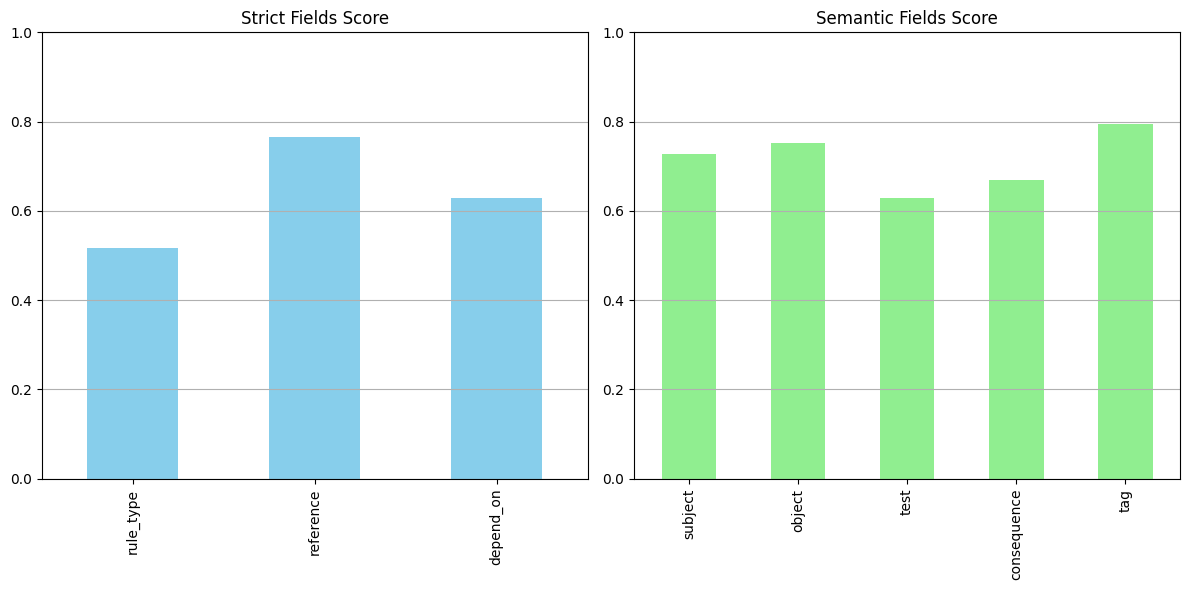

规则级评估报告：
规则数量一致性=54.55%
规则ID一致性=90.00%
字段级评估报告：

严格字段准确率：


,Field,Accuracy
0,rule_type,0.516667
1,reference,0.766667
2,depend_on,0.629167



语义字段平均分：


,Field,Score
0,subject,0.727667
1,object,0.751667
2,test,0.628125
3,consequence,0.670042
4,tag,0.794917



总体统计：
严格字段平均准确率：63.75%
语义字段平均得分：71.45%
所有字段平均得分：69.30%


In [7]:
# ====================
# 结果统计与可视化
# ====================
# 转换为DataFrame
df = pd.DataFrame(results)

# 计算各字段平均分
strict_avg = df[STRICT_FIELDS].mean().to_dict()
semantic_avg = df[SEMANTIC_FIELDS].mean().to_dict()

# 生成可视化报告
plt.figure(figsize=(12, 6))

# 严格字段F1可视化
plt.subplot(1, 2, 1)
pd.Series(strict_avg).plot(kind='bar', color='skyblue')
plt.title('Strict Fields Score')
plt.ylim(0, 1)
plt.grid(axis='y')

# 语义字段评分可视化
plt.subplot(1, 2, 2)
pd.Series(semantic_avg).plot(kind='bar', color='lightgreen')
plt.title('Semantic Fields Score')
plt.ylim(0, 1)
plt.grid(axis='y')

plt.tight_layout()
plt.show()

# ====================
# 打印详细报告
# ====================
print("="*40)
print("规则级评估报告：")
rule_level_num_con = num_con_rules/total_samples
rule_level_ID_con = total_con_rules/total_rules
print(f'规则数量一致性={rule_level_num_con:.2%}')
print(f'规则ID一致性={rule_level_ID_con:.2%}')
print("="*40)
print("字段级评估报告：")
print("="*40)
print("\n严格字段准确率：")
display(pd.DataFrame({
    'Field': STRICT_FIELDS,
    'Accuracy': [strict_avg[f] for f in STRICT_FIELDS]
}))

print("\n语义字段平均分：")
display(pd.DataFrame({
    'Field': SEMANTIC_FIELDS,
    'Score': [semantic_avg[f] for f in SEMANTIC_FIELDS]
}))

print("\n总体统计：")
avg_strict = sum(strict_avg.values())/len(strict_avg)
avg_semantic = sum(semantic_avg.values())/len(semantic_avg)
avg_score = (rule_level_num_con+rule_level_ID_con+3*avg_strict + 5*avg_semantic)/10
print(f"严格字段平均准确率：{avg_strict:.2%}")
print(f"语义字段平均得分：{avg_semantic:.2%}")
print(f"所有字段平均得分：{avg_score:.2%}")



In [8]:

# ====================
# 文件输出配置
# ====================
REPORT_PATH = PRED_JSON_PATH.split(".")[0]+"_evaluation_report.md"  # 支持.md或.txt

# ====================
# 生成报告内容
# ====================
report_content = f"""
# 规则抽取评估报告

## 评估配置
- 预测文件：`{PRED_JSON_PATH}`
- 真实数据：`{GT_JSON_PATH}`
- 评估时间：{pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S")}

## 规则级准确率：
- **规则数量一致性**：{rule_level_num_con:.2%}'
- **规则ID一致性**：{rule_level_ID_con:.2%}'

## 严格字段准确率
{df[STRICT_FIELDS].mean().to_markdown()}

## 语义字段得分
{df[SEMANTIC_FIELDS].mean().to_markdown()}

## 总体统计
- **严格字段平均准确率**：{avg_strict:.2%}
- **语义字段平均得分**：{avg_semantic:.2%}
- **综合得分（0.5*严格+0.5*语义）**：{avg_score:.2%}

![评估图表]({CHART_PATH})
"""


# ====================
# 写入报告文件
# ====================
with open(REPORT_PATH, 'w', encoding='utf-8') as f:
    f.write(report_content)
    
print(f"评估报告已保存至：{REPORT_PATH}")

NameError: name 'CHART_PATH' is not defined